In [106]:
import stim, pymatching as pm, numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt

there were 36 wrong predictions (logical errors) out of 100000 shots. p_L = 0.036 %


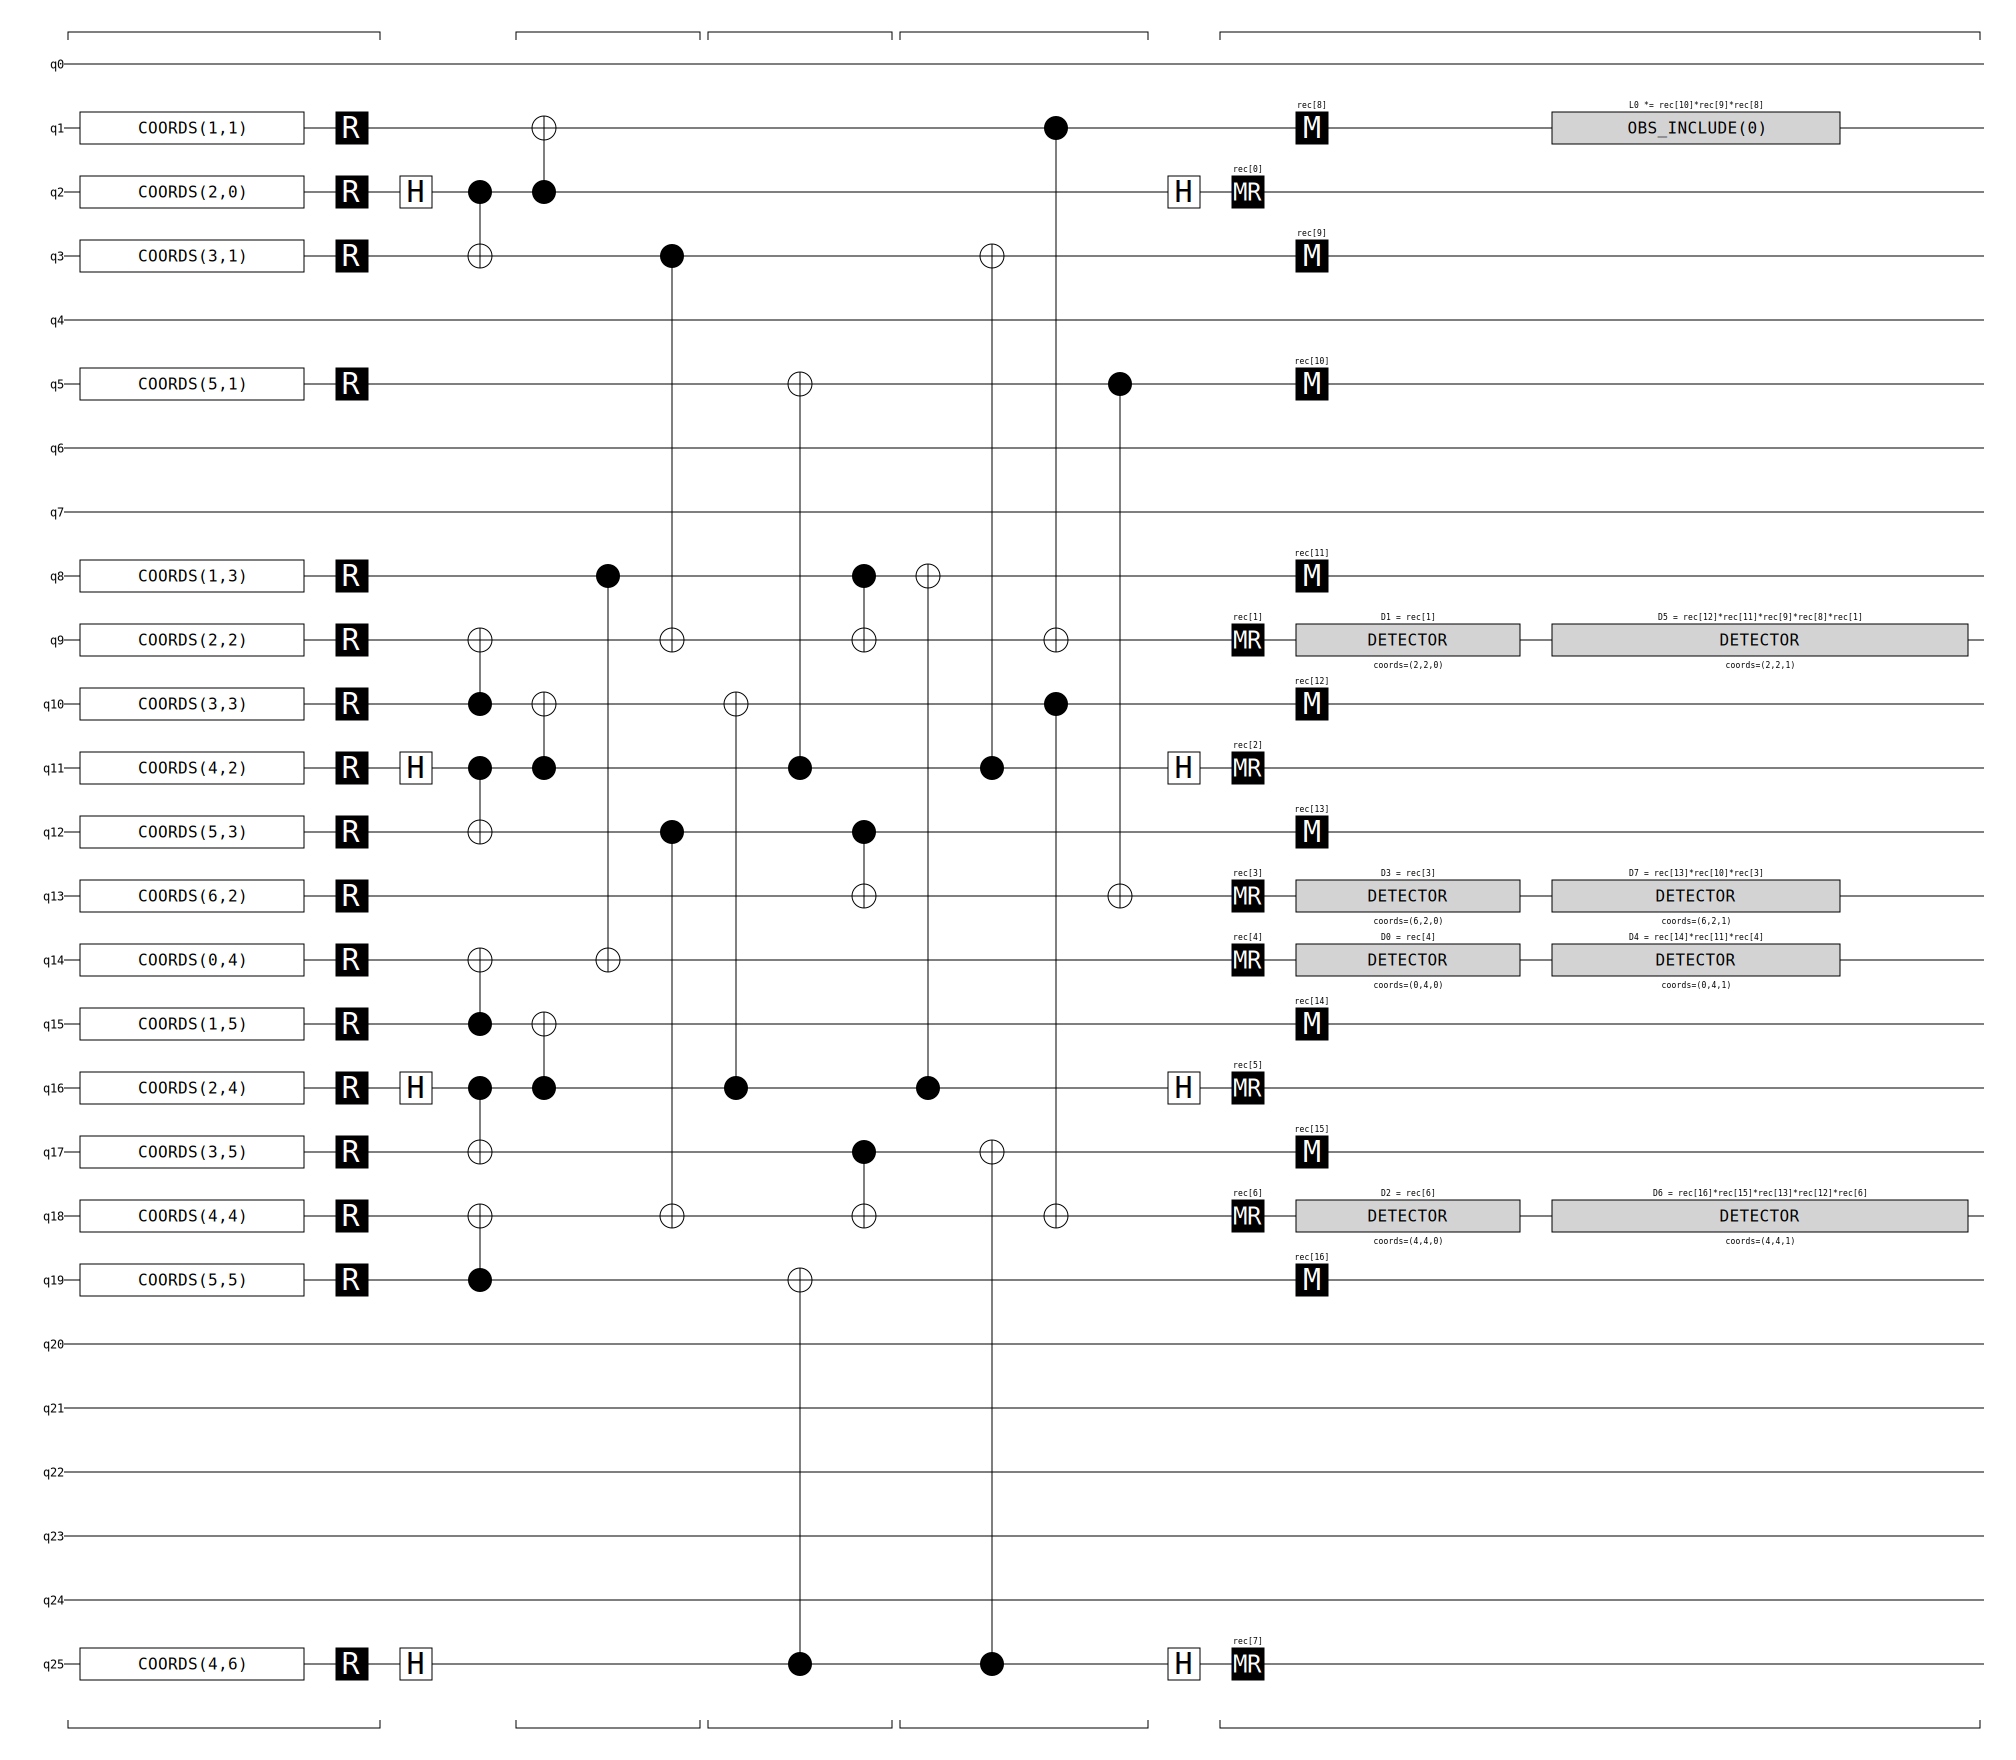

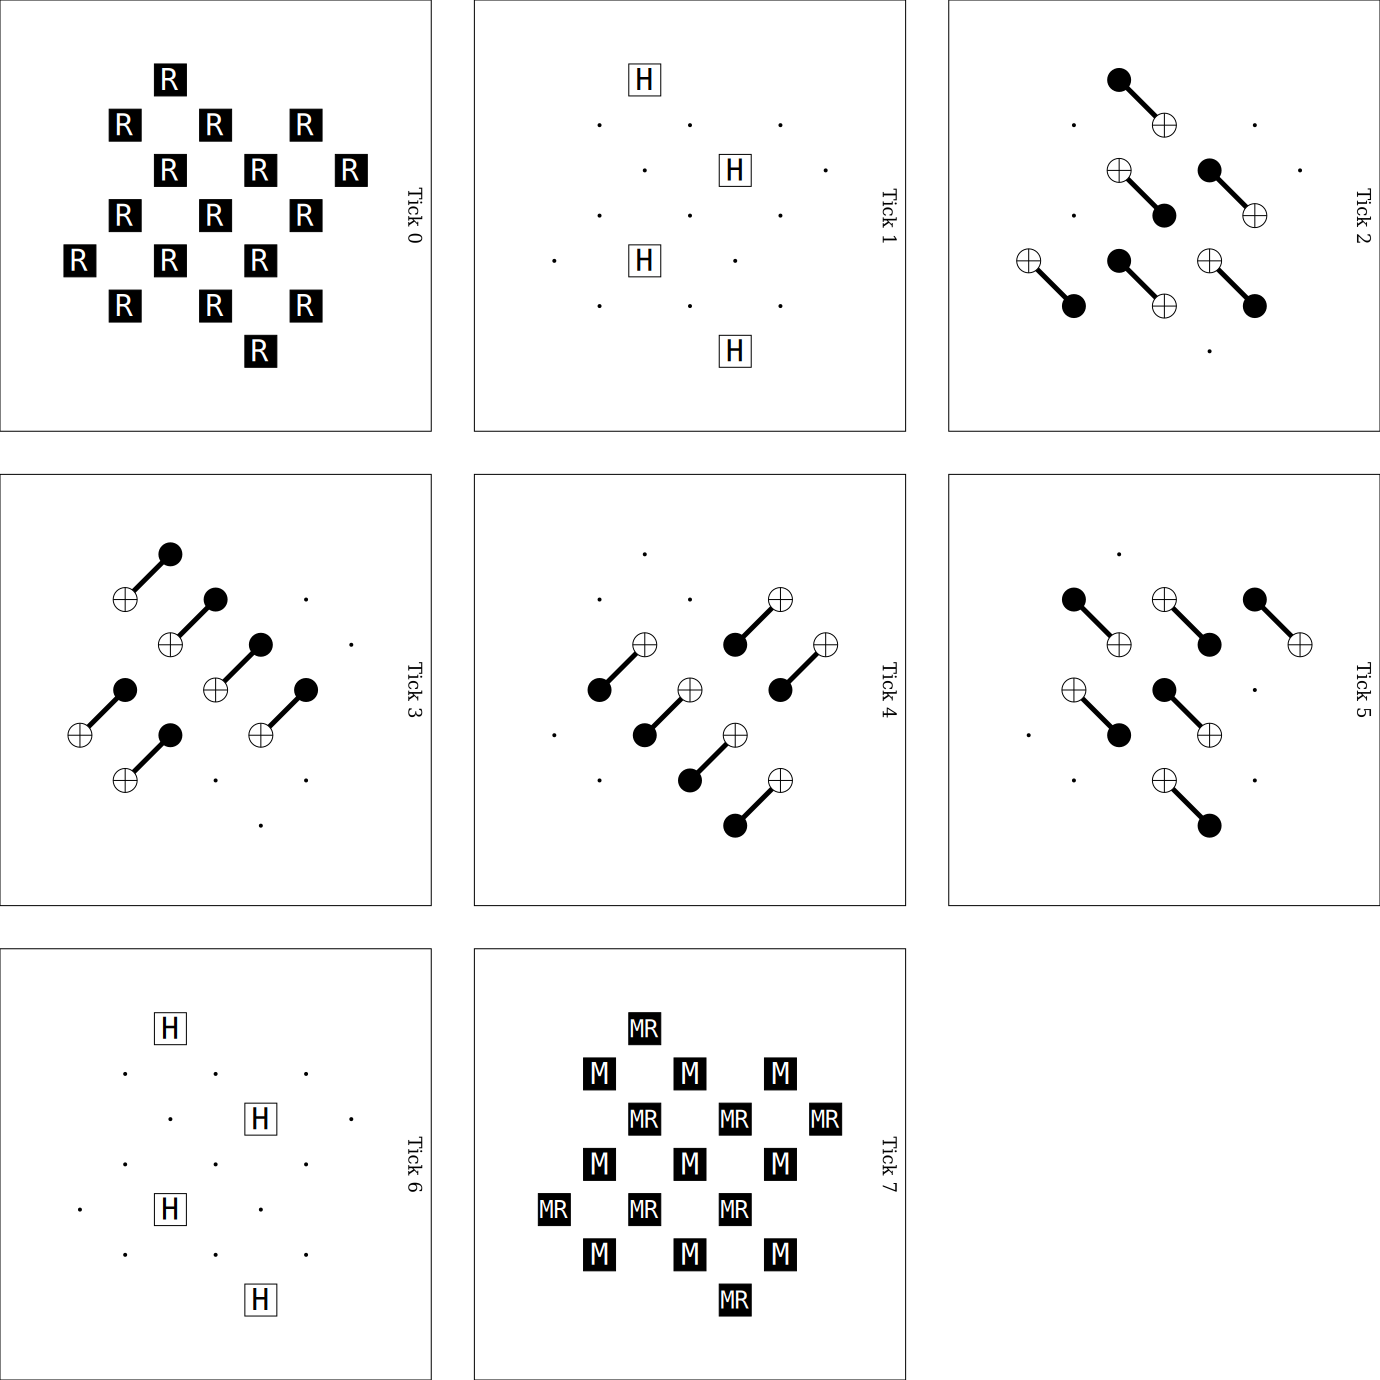

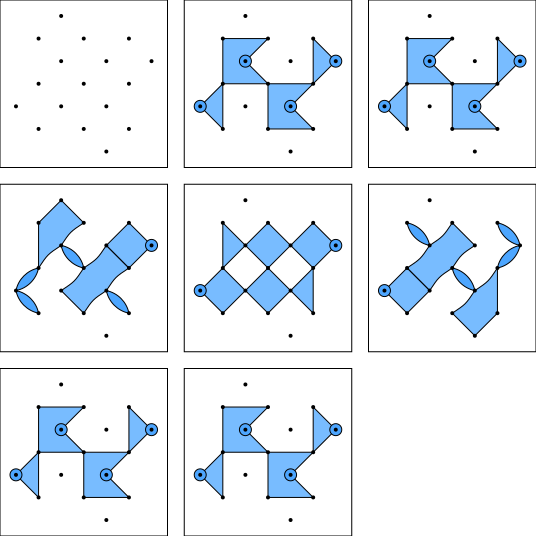

In [116]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pm.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

c = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

num_shots = 100_000
num_logical_errors = count_logical_errors(c, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots. p_L =", round(num_logical_errors / num_shots * 100, 5), "%")

display(c.without_noise().diagram("timeline-svg"))
display(c.without_noise().diagram("timeslice-svg"))
display(c.without_noise().diagram("detslice-svg"))



QUBIT_COORDS(0, 0, 0) 0
QUBIT_COORDS(0, 1, 0) 1
QUBIT_COORDS(0, 2, 0) 2
QUBIT_COORDS(1, 0, 0) 3
QUBIT_COORDS(1, 1, 0) 4
QUBIT_COORDS(1, 2, 0) 5
QUBIT_COORDS(2, 0, 0) 6
QUBIT_COORDS(2, 1, 0) 7
QUBIT_COORDS(2, 2, 0) 8
QUBIT_COORDS(0.5, 0.5, 0) 9
QUBIT_COORDS(0.5, 1.5, 0) 10
QUBIT_COORDS(1.5, 0.5, 0) 11
QUBIT_COORDS(1.5, 1.5, 0) 12
R 9 12 10 11
TICK
H 10 11
TICK
CX 4 9 8 12
TICK
CX 10 5 11 7
TICK
CX 3 9 7 12
TICK
CX 10 4 11 6
TICK
CX 0 9 4 12
TICK
CX 10 1 11 3
TICK
CX 1 9 5 12
TICK
CX 10 2 11 4
TICK
H 10 11
TICK
M 9 12 10 11
DETECTOR rec[-4]
DETECTOR rec[-3]
DETECTOR rec[-2]
DETECTOR rec[-1]
TICK
M 3 4 5
OBSERVABLE_INCLUDE(0) rec[-1] rec[-2] rec[-3]


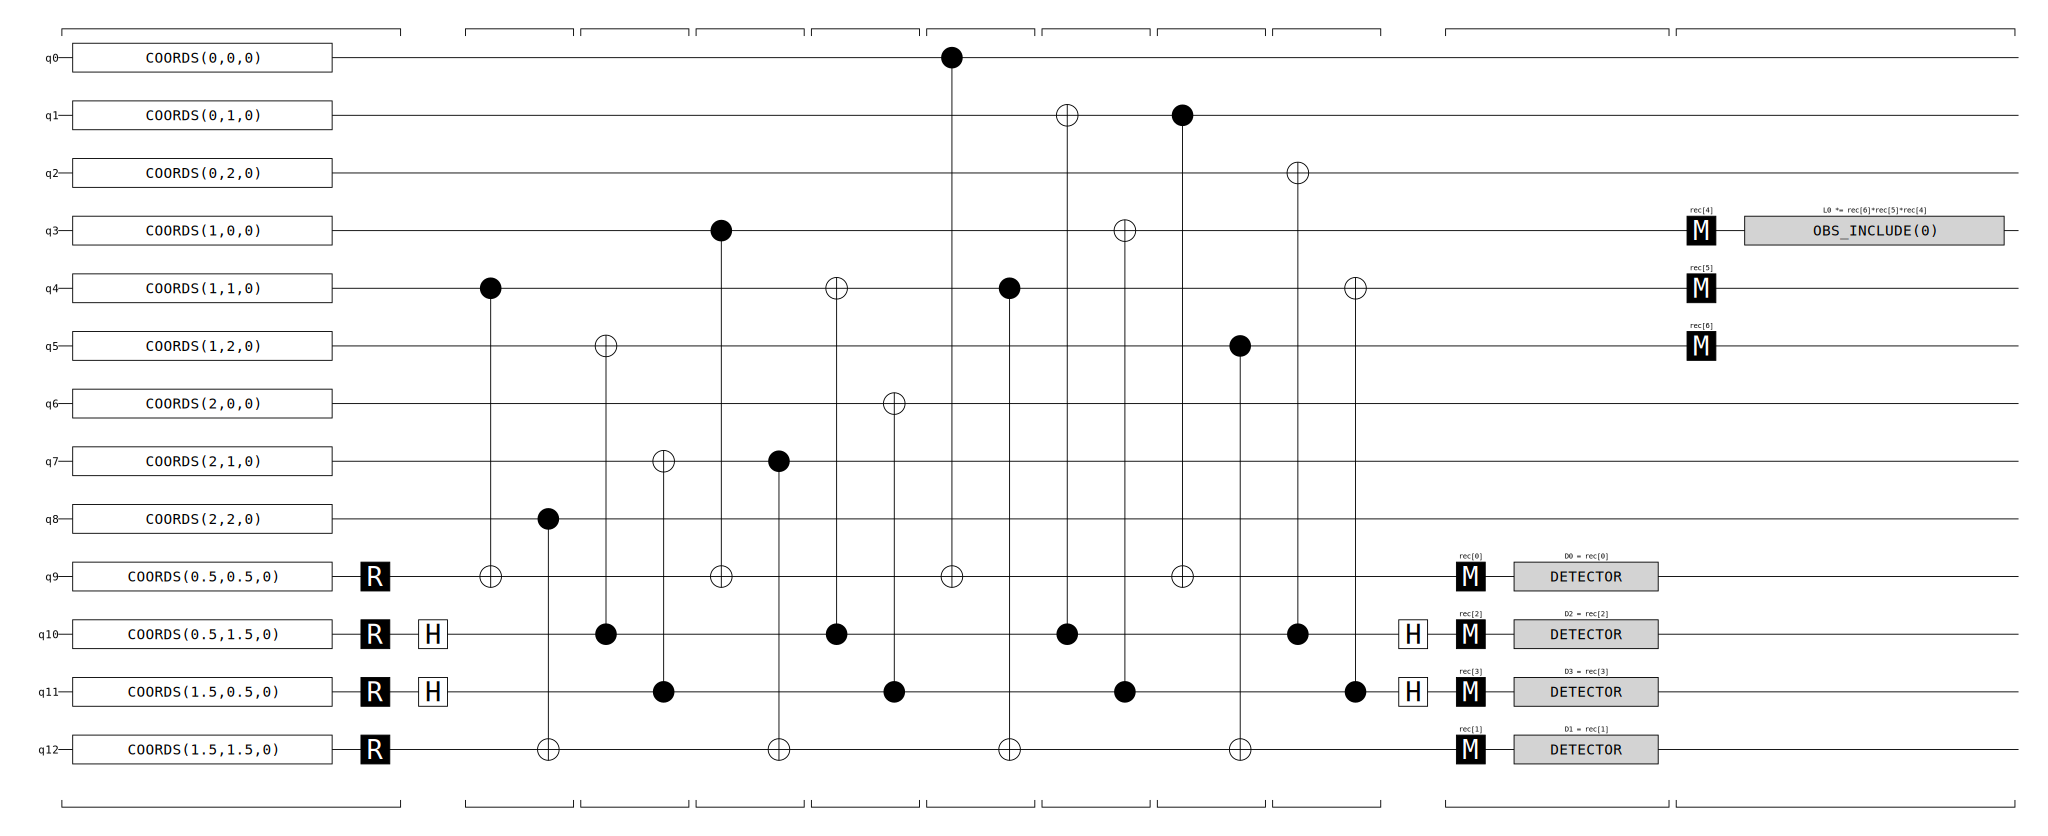

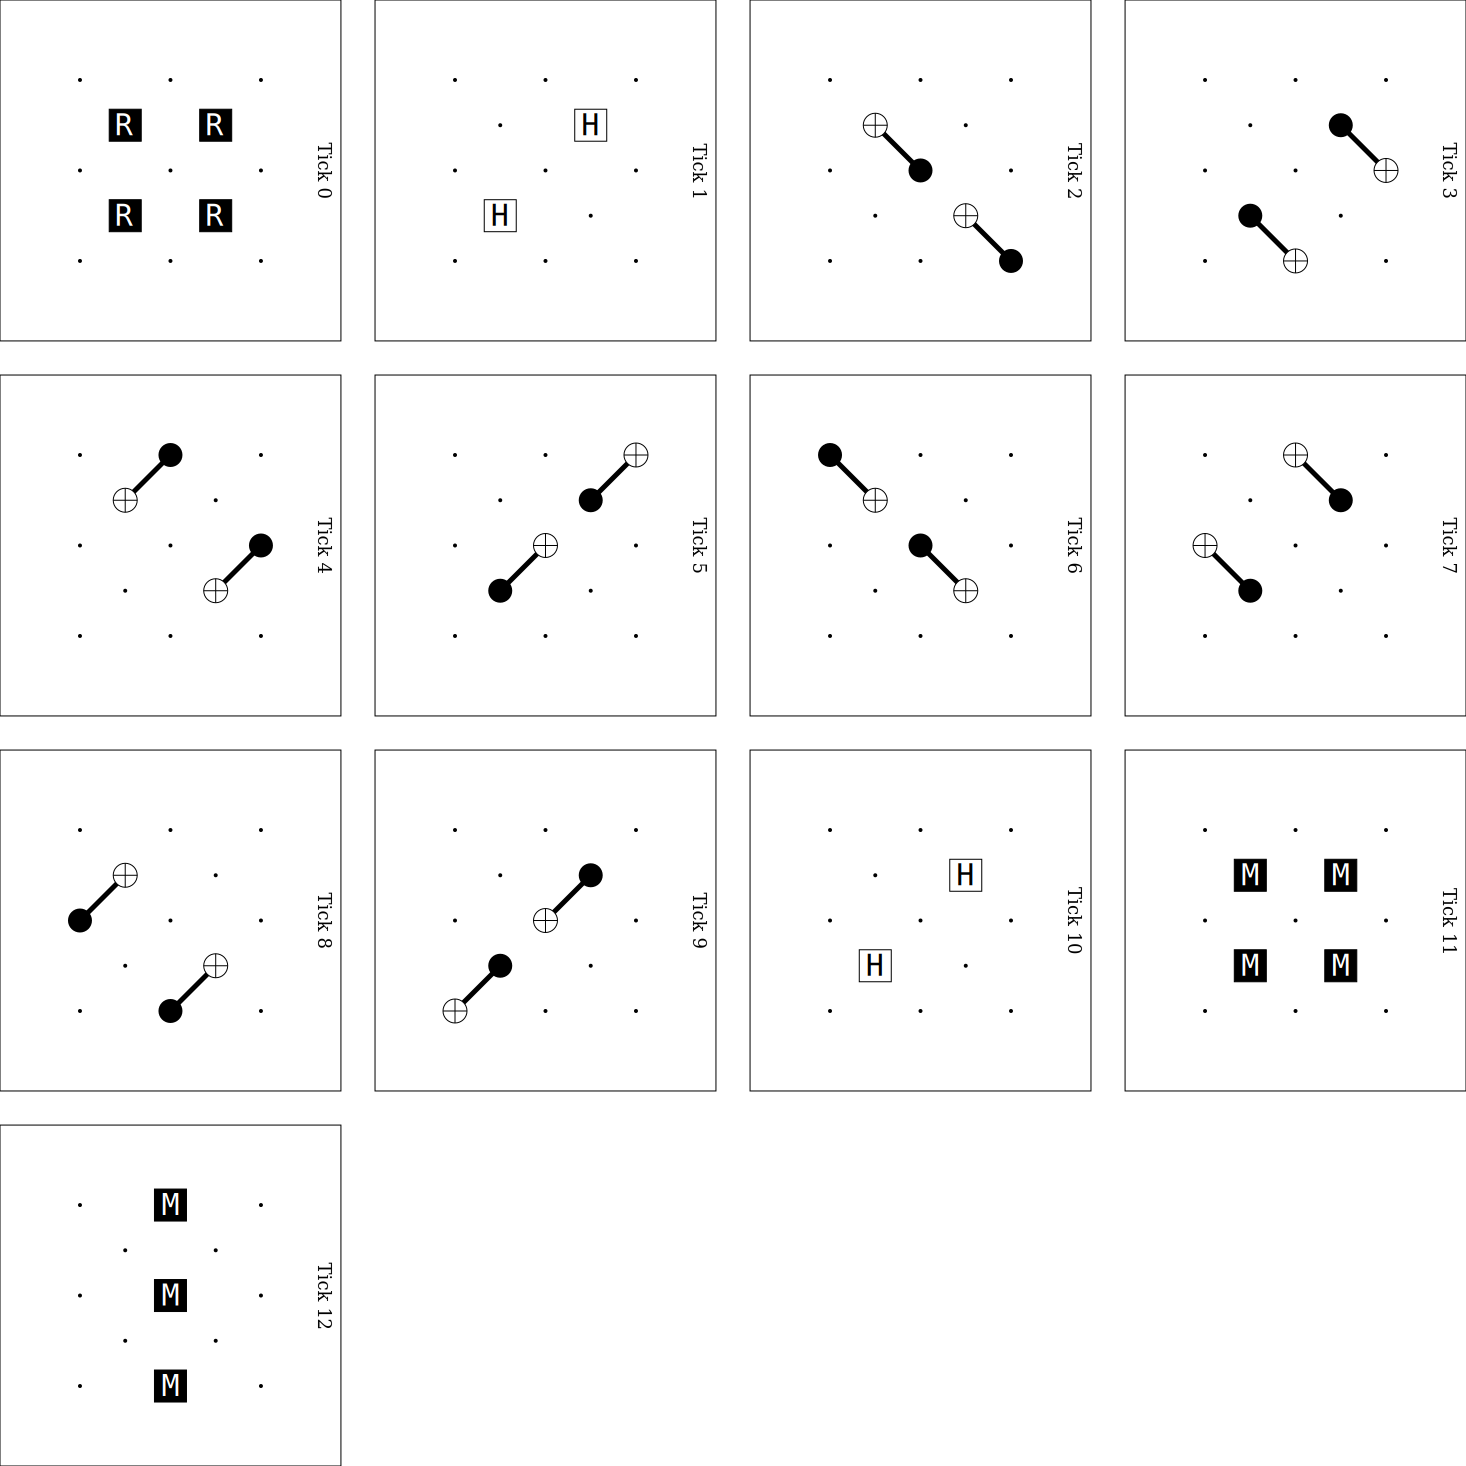

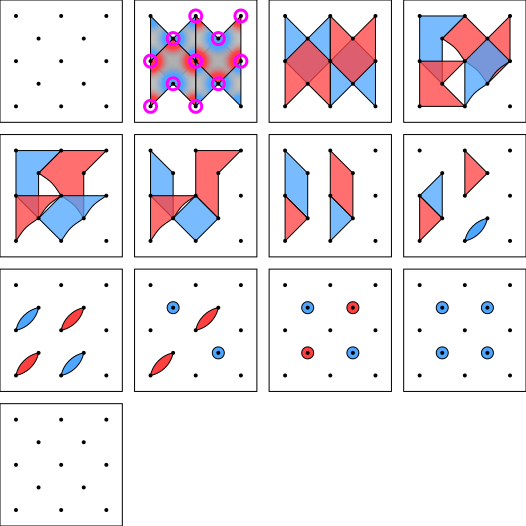

In [119]:
# rotated_memory_z_d3_manual_noiseless.py
import stim

# ---- geometry for rotated d=3 ----
# data qubits on a 3x3 grid of integer coords
data_xy = [(x, y) for x in range(3) for y in range(3)]             # 9 data qubits
# ancillas at centers of the 2x2 faces (checkerboard X/Z types)
faces = []
for x in range(2):
    for y in range(2):
        cx, cy = x + 0.5, y + 0.5
        typ = "Z" if (x + y) % 2 == 0 else "X"                      # checkerboard
        nbrs = [(x, y), (x+1, y), (x, y+1), (x+1, y+1)]             # up to 4 neighbors
        faces.append(((cx, cy), typ, nbrs))

# index assignment
q_index = {}
next_q = 0
for xy in data_xy:
    q_index[("D", xy)] = next_q; next_q += 1
for fidx in range(len(faces)):
    q_index[("A", fidx)] = next_q; next_q += 1

data_qubits = [q_index[("D", xy)] for xy in data_xy]
z_ancillas  = [q_index[("A", i)] for i,(_,t,_) in enumerate(faces) if t=="Z"]
x_ancillas  = [q_index[("A", i)] for i,(_,t,_) in enumerate(faces) if t=="X"]

# precompute per-direction CX layers (8-step schedule scaffold: NE, SE, SW, NW for Z then X)
def edge_dir(ax, ay, dx, dy):
    sx = 1 if dx-ax>0 else -1
    sy = 1 if dy-ay>0 else -1
    return {(+1,+1):"NE", (+1,-1):"SE", (-1,-1):"SW", (-1,+1):"NW"}[(sx,sy)]

DIRS = ("NE","SE","SW","NW")
z_pairs = {d: [] for d in DIRS}   # data -> ancilla (Z checks sense X errors)
x_pairs = {d: [] for d in DIRS}   # ancilla -> data (X checks sense Z errors)

for fidx,(cxy,typ,nbrs) in enumerate(faces):
    a = q_index[("A", fidx)]
    ax, ay = cxy
    for (dx,dy) in nbrs:
        dq = q_index[("D",(dx,dy))]
        d = edge_dir(ax,ay,dx,dy)
        if typ=="Z":
            z_pairs[d].append((dq,a))   # control=data, target=anc
        else:
            x_pairs[d].append((a,dq))   # control=anc,  target=data

# logical-Z path (vertical string along x=1 for d=3)
logical_Z_path = [q_index[("D",(1,y))] for y in range(3)]

# ---- build circuit (no noise) ----
c = stim.Circuit()

# (optional) coords for nicer diagrams
for (x,y) in data_xy:
    c.append("QUBIT_COORDS", [q_index[("D",(x,y))]], [float(x), float(y), 0.0])
for fidx,(cxy,_,_) in enumerate(faces):
    c.append("QUBIT_COORDS", [q_index[("A",fidx)]], [float(cxy[0]), float(cxy[1]), 0.0])

# Tick 0: reset ancillas to |0>
if z_ancillas: c.append("R", z_ancillas)
if x_ancillas: c.append("R", x_ancillas)
c.append("TICK")

# Tick 1: put X-type ancillas into |+> with H
if x_ancillas: c.append("H", x_ancillas)
c.append("TICK")

# Ticks 2–5: four CNOT layers per hook-avoiding schedule
for d in DIRS:
    if z_pairs[d]:
        flat = [q for pair in z_pairs[d] for q in pair]
        c.append("CX", flat)   # data->ancilla
    c.append("TICK")
    if x_pairs[d]:
        flat = [q for pair in x_pairs[d] for q in pair]
        c.append("CX", flat)   # ancilla->data
    c.append("TICK")

# Tick 6: undo H on X-type ancillas (to measure X via Z-basis)
if x_ancillas: c.append("H", x_ancillas)
c.append("TICK")

# Tick 7: measure ancillas (Z basis). One round only, so detectors just equal these outcomes.
meas_order = z_ancillas + x_ancillas
if meas_order:
    c.append("M", meas_order)
    # place one DETECTOR per ancilla = rec of that measurement (no time difference since rounds=1)
    for k,_a in enumerate(meas_order):
        c.append("DETECTOR", [stim.target_rec(-len(meas_order)+k)])
c.append("TICK")

# Logical Z readout along the chosen boundary string
if logical_Z_path:
    c.append("M", logical_Z_path)
    c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-i) for i in range(1, len(logical_Z_path)+1)], 0)

print(c)  # see the text circuit
display(c.without_noise().diagram("timeline-svg"))
display(c.without_noise().diagram("timeslice-svg"))
display(c.without_noise().diagram("detslice-svg"))